## 2. notebook for looking at 2ds data
similar to extracting individual crystals, but firstly we want to seperate out (with certainty) whole crystals vs noise (i.e. lots of small particles)

In [119]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
#from IPython.display import display #
#import cv2 # not working
import os

from scipy.ndimage import convolve
from scipy.ndimage import label
from skimage.measure import regionprops

In [120]:
## files location
ds_loc = '/home/users/esree/data/2ds/'
hvps_loc = '/home/users/esree/data/hvps/'

#file of interest
file_name = 'Export_base220730153000.h5' # example file
f2ds = h5py.File(ds_loc+ file_name,'r') # open file

# break file into two - data + time
ds_image = f2ds['ImageData'] 
ds_time = f2ds['ImageTimes']
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##### make xarray of useful time data #####
sec_since = ds_time[:,0]
pixel_slice = ds_time[:,1]
pix_sum = pixel_slice.cumsum(dtype = 'int')

## make useful datetime format (not seconds since midnight)
# using the file name for reference
date_str = file_name[11:17]
starting_date = datetime.strptime(date_str, '%y%m%d')
time_deltas = [timedelta(seconds=float(sec)) for sec in sec_since]
utc_time = [starting_date + delta for delta in time_deltas]

time_xr =xr.Dataset({
    'utc_time':utc_time,
    'pixel_slice': pixel_slice,
    'pix_sum': pix_sum})
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### first step in cleaning
* get rid of images where less than 4 pixels along x axis

In [121]:
diff = np.diff(time_xr['pix_sum'][:].values) # this is finding the difference between the elements of pix_sum
selected_values = time_xr['pix_sum'][:-1][diff > 4] # this is selecting the adjacent files in which have pixels > 4 length
# i.e. selected values contains the index of where images are > 4 in x axis

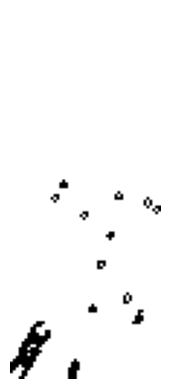

In [141]:
i = 2344 # random crystal
## 32 is good example, 700 - we would want rid of
one_crystal = f2ds['ImageData'][:,int(selected_values[i]):int(selected_values[i+1])] # extract 1 crystal

plt.imshow(one_crystal, cmap='gray')
plt.axis('off') # Turn off axis labels
plt.show()

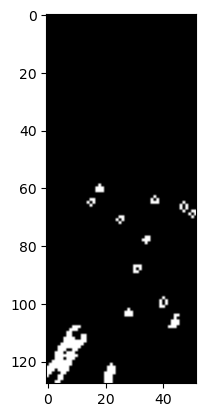

In [142]:
# so if we have an image with multiple things inside, we just want the biggest crystal -> want to return the index of these, so can just use it to extract it
# Convert the dataframe to a binary image where 0 is True (activated) and all else is False
binary_image = (one_crystal == 0)

# Label the connected components
labeled_image, num_features = label(binary_image)

plt.imshow(binary_image, cmap='gray')

props = regionprops(labeled_image)
if props:
    # Find the component with the maximum area
    largest_component = max(props, key=lambda x: x.area)
    print(largest_component)

    # Extract x-values (column indices) of the largest component
    coords = largest_component.coords
    x_values = np.unique(coords[:, 1])  # column indices are the x-values
else:
    x_values = np.array([])  # No components found

In [143]:
## taking our cleaned data, where the files are >4 in length

# 1. want to find the objects in the sections
# 2. identify objects in which the area is > than specific threshold
# 3. extract start + end index of said particle
# 4. use this index to slice + get corresponding UTC time associated with particle

area_threshold = 30 # need this minimum number of pixels to be classified
binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false

# Label the connected components
labeled_image, num_features = label(binary_image) # identify connected true areas
# labeled_image = array, with each true area given a number to identify them
# num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate).

props = regionprops(labeled_image) # creates list of properties describing each feature detected in the image.
# has: label, area, centroid, bounding box - for each feature (did personally count area of 1 to check, and does it correctly)

## only doing this if anything there i.e. if props
## want to extract only particles that surpass area threshold 
# first need to count how many are present 
if props:
    n_big_particles = 0
    for particle in props:
        if particle.area >= area_threshold:
            n_big_particles += 1 

    # this is nice and easy, extract the property
    if n_big_particles == 1:
        for particle in props:
            if particle.area >= area_threshold:
                coords = largest_component.coords # basically gives coords of each point of interest
                x_values = np.unique(coords[:, 1])
                s_idx = int(selected_values[i] + x_values[0])
                e_idx = int(selected_values[i] + x_values[-1])

    # not really sure what to do yet if more than 1
    elif n_big_particles > 1:
        print('fuck')
        multi = {}
        for particle in props:
            if particle.area >= area_threshold:
                coords = largest_component.coords # basically gives coords of each point of interest
                x_values = np.unique(coords[:, 1])
                s_idx = int(selected_values[i] + x_values[0])
                e_idx = int(selected_values[i] + x_values[-1])
                multi[particle.label] = [coords[0][0],coords[-1][0],s_idx,e_idx] # y1,y2,x1,x2 - x values are our index also needed for extracting time
                    # i.e. [f2ds['ImageData'][y1:y2,x1:x2]
                
       
print(coords[0][0])
print(coords[-1][0])

108
127


108
127
183679
183692


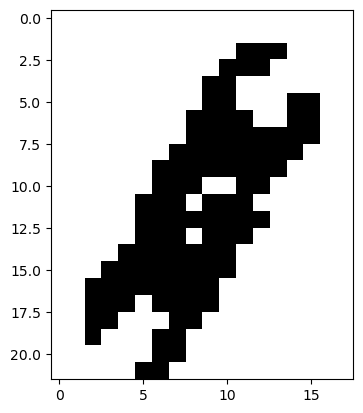

In [144]:
## taking our cleaned data, where the files are >4 in length

# 1. want to find the objects in the sections
# 2. identify objects in which the area is > than specific threshold
# 3. extract start + end index of said particle
# 4. use this index to slice + get corresponding UTC time associated with particle

area_threshold = 30 # need this minimum number of pixels to be classified
binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false

# Label the connected components
labeled_image, num_features = label(binary_image) # identify connected true areas
# labeled_image = array, with each true area given a number to identify them
# num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate).

props = regionprops(labeled_image) # creates list of properties describing each feature detected in the image.
# has: label, area, centroid, bounding box - for each feature (did personally count area of 1 to check, and does it correctly)

## only doing this if anything there i.e. if props
## want to extract only particles that surpass area threshold 
# first need to count how many are present 
if props:
    n_big_particles = 0
    for particle in props:
        if particle.area >= area_threshold:
            multi = {}
            coords = largest_component.coords # basically gives coords of each point of interest
            x_values = np.unique(coords[:, 1])
            s_idx = int(selected_values[i] + x_values[0])
            e_idx = int(selected_values[i] + x_values[-1])
            multi[particle.label] = [coords[0][0],coords[-1][0],s_idx,e_idx] # y1,y2,x1,x2 
                # x values are our index also needed for extracting time
                # i.e. [f2ds['ImageData'][y1:y2,x1:x2]
                

for key in multi:
    for i in range(4):
        print(multi[key][i])

keys = list(multi.keys())
extract = f2ds['ImageData'][multi[keys[0]][0]-2:multi[keys[0]][1]+3,multi[keys[0]][2] -2:multi[keys[0]][3]+3] ## added 2 pixel buffer around single crystal

plt.imshow(extract, cmap='gray')

In [ ]:
'''
#num_features
plt.imshow(labeled_image)
plt.colorbar()
'''
'''
# go though each object, and loop through their respective properties.
for region in props:
    print("Label:", region.label)
    print("Area:", region.area)
    print("Centroid:", region.centroid)
    print("Bounding box:", region.bbox)
    '''

extract = f2ds['ImageData'][coords[0][0]-2:coords[-1][0]+3,s_idx -2:e_idx+3] ## added 2 pixel buffer around single crystal
#extract = f2ds['ImageData'][:,s_idx:e_idx]

#extract = f2ds['ImageData'][y_values[1]:y_values[1]+y_values[0],s_idx:e_idx]

plt.imshow(extract, cmap='gray')

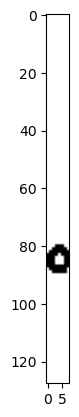

In [74]:
#selected_values[i]
big_crystal = f2ds['ImageData'][:,int(selected_values[i]):int(selected_values[i]+x_values[-1])] # extract 1 crystal)
plt.imshow(big_crystal, cmap='gray')

In [ ]:
## more chat code - to count number of adjacent pixels (can work out area)
## possiblt more useful - can use to extract just big pixels

def count_adjacent_activated_pixels(binary_image):
    # Define a 3x3 kernel that counts neighbors
    # Ignore the center pixel by setting its weight to 0
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    
    # Apply convolution to count adjacent activated pixels
    neighbor_count = convolve(binary_image.astype(int), kernel, mode='constant', cval=0)
    return neighbor_count

# Example usage
binary_image = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], dtype=bool)

adjacent_counts = count_adjacent_activated_pixels(binary_image)
print(adjacent_counts)


In [ ]:
## this is chat code, to identify components in the image - where there are connected parts / scattered noise
import numpy as np
import h5py
from scipy.ndimage import label, find_objects
from skimage.measure import regionprops

def load_image_from_h5(file_path, key):
    with h5py.File(file_path, 'r') as file:
        image_data = np.array(file[key])
    return image_data

def preprocess_image(image, threshold=250):
    # Threshold the image to make it binary
    binary_image = image > threshold
    return binary_image

def analyze_image(image):
    # Label connected components
    labeled_image, num_features = label(image)
    properties = regionprops(labeled_image)
    sizes = [prop.area for prop in properties]
    
    # You can adjust these thresholds based on what you consider as noise
    noise_threshold = 500  # Change as per your specific needs
    large_components = [size for size in sizes if size > noise_threshold]

    if len(large_components) == 1:
        print("Image is mostly continuous.")
    elif len(large_components) > 1:
        print("Image has multiple large parts.")
    else:
        print("Image is noisy or has no significant parts.")

# Example usage
file_path = 'your_data.h5'
key = 'dataset_key'  # Update with the actual dataset key in your H5 file
image = load_image_from_h5(file_path, key)
preprocessed_image = preprocess_image(image)
analyze_image(preprocessed_image)